<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>From tensorflow model training to scoring with</b></font><font face="monospace" size="4" color="darkblue"><b> watson-machine-learning-client</b></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/scikit-learn/hand-written-digits-recognition/images/numbers_banner-04.png" width="600" alt="Icon"></td>
   </tr>
</table>

This notebook contains steps and code to demonstrate support of Deep Learning model training and scoring in Watson Machine Learning service. This notebook introduces commands for getting data, training_definition persistance to Watson Machine Learning repository, model training, model persistance, model deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.


## Learning goals

The learning goals of this notebook are:

-  Working with Watson Machine Learning service.
-  Training Deep Learning models (TensorFlow).
-  Saving trained models in Watson Machine Learning repository.
-  Online deployment and scoring of trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Train TensorFlow model](#model)
3.	[Persist model](#save)
4.	[Deploy model](#deploy)
5.	[Score](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a [Watson Machine Learning Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a lite plan is offered). 
-  Create [Cloud Object Storage (COS)](https://console.bluemix.net/catalog/infrastructure/cloud-object-storage) instance (a lite plan is offered).
    + After you create COS instance, go to your COS dashboard.
    + In _Service credentials_ tab, click on _New Credential_,
    + Add inline configuration parameter: `{"HMAC":true}`, click _Add_

### 1.1 Working with Cloud Object Storage

`ibm-cos-sdk` library allows Python developers to manage Cloud Object Storage (COS).

In [1]:
import ibm_boto3
from ibm_botocore.client import Config

**Action**: Put authentication information from your instance of Cloud Object Storage service here.

In [2]:
cos_credentials = {
  "apikey": "***",
  "cos_hmac_keys": {
    "access_key_id": "***",
    "secret_access_key": "***"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "***",
  "iam_apikey_name": "***",
  "iam_role_crn": "***",
  "iam_serviceid_crn": "***",
  "resource_instance_id": "***"
}
cos_credentials = {
  "apikey": "-2WHSk0VEvocPMen6qbEQUVfg1V0TiEGiqL4mJLQsuE8",
  "cos_hmac_keys": {
    "access_key_id": "b4eb1ddef8c9436ab77e2a5ecb089277",
    "secret_access_key": "48c120b23cf8ddd3935c600571adf0c9f696378ce6f0048a"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/8dba8395f5b8dc6fcab49d43161ab9f1:f037911e-7eae-4f79-994b-b6605e50392a::",
  "iam_apikey_name": "auto-generated-apikey-b4eb1dde-f8c9-436a-b77e-2a5ecb089277",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/8dba8395f5b8dc6fcab49d43161ab9f1::serviceid:ServiceId-eb5df9e5-4d0e-4d0b-a9a2-fb87cf4687b0",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/8dba8395f5b8dc6fcab49d43161ab9f1:f037911e-7eae-4f79-994b-b6605e50392a::"
}

**Action:** Define the service endpoint we will use. <br>
**Tip:** You can find this information in _Endpoints_ section of your Cloud Object Storage intance's dashbord.

In [3]:
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

You also need IBM Cloud authorization endpoint to be able to create COS resource object.

In [4]:
auth_endpoint = 'https://iam.bluemix.net/oidc/token'

We create COS resource to be able to write data to Cloud Object Storage.

In [5]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                         ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Let's create the buckets (they have to have unique names), we will use to store training data and training results.

In [6]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = ['training-data-' + bucket_uid, 'training-results-' + bucket_uid]

for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "training-data-2086a31d-1544-4cf5-ac80-129f83d17b6e"...
Creating bucket "training-results-2086a31d-1544-4cf5-ac80-129f83d17b6e"...


Now we should have 2 buckets,

### 1.2 Downloading training data and upload it to COS buckets.

Let's download our training data and upload them to 'training-data' bucket.
We will create a list of links for training dataset

In [7]:
data_links = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

Below snippet will upload files from links to your Cloud Object Storage.

In [8]:
from urllib.request import urlopen

bucket_obj = cos.Bucket(buckets[0])

for data_link in data_links:
    filename=data_link.split('/')[-1]
    print('Uploading data {}...'.format(filename))
    with urlopen(data_link) as data:
        bucket_obj.upload_fileobj(data, filename)
        print('{} is uploaded.'.format(filename))

Uploading data train-images-idx3-ubyte.gz...
train-images-idx3-ubyte.gz is uploaded.
Uploading data train-labels-idx1-ubyte.gz...
train-labels-idx1-ubyte.gz is uploaded.
Uploading data t10k-images-idx3-ubyte.gz...
t10k-images-idx3-ubyte.gz is uploaded.
Uploading data t10k-labels-idx1-ubyte.gz...
t10k-labels-idx1-ubyte.gz is uploaded.


Let's see the list of all created buckets and their contents.

In [9]:
for bucket_name in buckets:
    print(bucket_name)
    bucket_obj = cos.Bucket(bucket_name)
    for obj in bucket_obj.objects.all():
        print("  File: {}, {:4.2f}kB".format(obj.key, obj.size/1024))

training-data-2086a31d-1544-4cf5-ac80-129f83d17b6e
  File: t10k-images-idx3-ubyte.gz, 1610.23kB
  File: t10k-labels-idx1-ubyte.gz, 4.44kB
  File: train-images-idx3-ubyte.gz, 9680.10kB
  File: train-labels-idx1-ubyte.gz, 28.20kB
training-results-2086a31d-1544-4cf5-ac80-129f83d17b6e


We are done with Cloud Object Storage, we are ready to train our model!

<a id="model"></a>
## 2. Train model

### 2.1 Work with the instance

In [10]:
import urllib3, requests, json, base64, time, os, wget

In [11]:
!pip install dask --upgrade

Requirement already up-to-date: dask in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages


Authenticate to Watson Machine Learning service on Bluemix.

**Action**: Put authentication information from your instance of Watson Machine Learning service here.

In [12]:
wml_credentials={
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "***",
  "username": "***",
  "password": "***",
  "instance_id": "***"
}
wml_credentials={
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "DIZV+iVeSeFlyCVyD08sAN3UTTiauJCyU/mPntj6MbfM201Vlm5XdPtDxm7YG/1spxSFKe9cZoFYLlzgPf++qpWZYcc+6fawL9S0V+2V79Adc+zik+ZHJYrsBRl9GAcs",
  "username": "84ff785f-ec45-4417-b6ce-30ee6534a5b1",
  "password": "d3940235-f599-4217-9d33-567cfce02353",
  "instance_id": "fd1db635-c9f3-4d83-afc7-32efec367e5e"
}

#### Install `watson-machine-learning-client` from pypi

In [13]:
!pip install watson-machine-learning-client --upgrade

Requirement already up-to-date: watson-machine-learning-client in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages
Requirement already up-to-date: lomond in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: tabulate in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: tqdm in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: requests in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sec7-2ac43fd194bc9a-8ef090487f81/.local/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: urllib3 in

#### Import `watson-machine-learning-client` and authenticate to service instance

In [14]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [15]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### 2.2 Save model definition 

#### Prepare model definition metadata

In [16]:
model_definition_metadata = {
            client.repository.DefinitionMetaNames.NAME: "my_definition",
            client.repository.DefinitionMetaNames.DESCRIPTION: "my_description",
            client.repository.DefinitionMetaNames.AUTHOR_NAME: "John Smith",
            client.repository.DefinitionMetaNames.AUTHOR_EMAIL: "js@js.com",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.2",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python3 tensorflow_mnist_softmax.py --trainingIters 20"
            }

#### Get sample model definition content file from git

In [17]:
filename='tf-softmax-model.zip'

if not os.path.isfile(filename):
    filename = wget('https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/hand-written-digit-recognition/definition/tf-softmax-model.zip')
    
print(filename)

tf-softmax-model.zip


#### Publish training definition in Watson Machine Learning repository

In [18]:
definition_details = client.repository.store_definition(filename, model_definition_metadata)

In [19]:
definition_uid = client.repository.get_definition_uid(definition_details)

In [20]:
print(definition_uid)

6c77d7d6-7a8b-4d44-96dd-e1fc7ae669d7


### 2.3 Train model

#### Prepare training configuration

**Action:** Put authentication information from your instance of Object Storage service here.
- `TRAINING_DATA_REFERENCE` (reference to uploaded training data)
- `TRAINING_RESULTS_REFERENCE` (location where trained model will be saved)

In [21]:
training_configuration_metadata = {
            client.training.ConfigurationMetaNames.NAME: "Hand-written Digit Recognition",
            client.training.ConfigurationMetaNames.AUTHOR_NAME: "John Smith",
            client.training.ConfigurationMetaNames.AUTHOR_EMAIL: "JohnSmith@js.com",
            client.training.ConfigurationMetaNames.DESCRIPTION: "Hand-written Digit Recognition training",
            client.training.ConfigurationMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.training.ConfigurationMetaNames.FRAMEWORK_VERSION: "1.2-py3",
            client.training.ConfigurationMetaNames.EXECUTION_COMMAND: "python3 tensorflow_mnist_softmax.py --trainingIters 20",
            #client.training.ConfigurationMetaNames.EXECUTION_RESOURCE_SIZE: "small",
            client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCE: {
                    "connection": {
                        "endpoint_url": service_endpoint,
                        "aws_access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                        "aws_secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                    },
                    "source": {
                        "bucket": buckets[0],
                    },
                    "type": "s3"
                },
            client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE: {
                "connection": {
                    "endpoint_url": service_endpoint,
                    "aws_access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                    "aws_secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                },
                "target": {
                    "bucket": buckets[1],
                },
                "type": "s3"
            },
        }

#### Train the model in the background

In [22]:
training_run_details = client.training.run(definition_uid, training_configuration_metadata)

In [23]:
training_run_guid_async = client.training.get_run_uid(training_run_details)

You can check status of training run by calling below method.

In [24]:
status = client.training.get_status(training_run_guid_async)
print(json.dumps(status, indent=2))

{
  "metrics": [],
  "submitted_at": "2018-01-31T11:45:01Z",
  "state": "pending",
  "current_at": "2018-01-31T11:45:15Z"
}


#### Monitor training log

You can turn on training log monitoring by calling below method.

In [25]:
client.training.monitor_logs(training_run_guid_async)



########################################################

Log monitor started for training run: training-KEjw8HjzR

########################################################


Status: PENDING

Training with training/test data at:
  DATA_DIR: /job/training-data-2086a31d-1544-4cf5-ac80-129f83d17b6e
  MODEL_DIR: /job/model-code
  TRAINING_JOB: 
  TRAINING_COMMAND: python3 tensorflow_mnist_softmax.py --trainingIters 20
Storing trained model at:
  RESULT_DIR: /job/training-results-2086a31d-1544-4cf5-ac80-129f83d17b6e
BAZEL_VERSION=0.4.5
CI_BUILD_PYTHON=python3
CUDA_PKG_VERSION=8-0=8.0.61-1
CUDA_VERSION=8.0.61

CUDNN_VERSION=5.1.10

DATA_DIR=/job/training-data-2086a31d-1544-4cf5-ac80-129f83d17b6e
GPU_COUNT=1.000000
HOME=/root
JOB_STATE_DIR=/job
LD_LIBRARY_PATH=/usr/local/cuda/extras/CUPTI/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64/stubs
LEARNER_ID=1
LIBRARY_PATH=/usr/local/cuda/lib64/stubs:

MODEL_DIR=/job/model-code
OLDPWD=/root

PATH=/usr/local/nvidia/bin:/u

#### Cancel training

You can cancel training run by calling below method.

#### Train the model in active mode

**Tip:** You can also run training in synchronous mode by setting `asynchronous = False`

In [26]:
training_run_details = client.training.run(definition_uid, training_configuration_metadata, asynchronous=False)



############################

Running 'training-YZSrUHCzg'

############################


Elapsed time: 0.09987664222717285 -> training state: pending


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 10.213050603866577 -> training state: pending



100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 20.327072858810425 -> training state: pending



100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 30.451308012008667 -> training state: pending



100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 40.56735801696777 -> training state: pending



100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Training of 'training-YZSrUHCzg' finished successfully.


You can see the status of training run similarly as before

In [27]:
training_run_uid_sync = client.training.get_run_uid(training_run_details)

In [28]:
status = client.training.get_status(training_run_uid_sync)
print(json.dumps(status, indent=2))

{
  "submitted_at": "2018-01-31T11:46:28Z",
  "state": "completed",
  "metrics": [],
  "finished_at": "2018-01-31T11:47:01Z",
  "current_at": "2018-01-31T11:47:09Z",
  "message": ""
}


<a id="model"></a>
## 3. Persist model

#### Call this method to save model in Watson Machine Learning repository

In [30]:
saved_model_details = client.repository.store_model(training_run_uid_sync, "My cool mnist model")

In [31]:
print("Url: " + client.repository.get_model_url(saved_model_details))

Url: https://ibm-watson-ml.mybluemix.net/v3/ml_assets/models/e4643014-a6c7-45a0-94cd-f52e00f62bf9


**Tip:** Run below code to extract stored model uid from dictionary.

In [32]:
model_uid = client.repository.get_model_uid(saved_model_details)
print("Saved model uid: " + model_uid)

Saved model uid: e4643014-a6c7-45a0-94cd-f52e00f62bf9


#### Call this method to list stored models

In [33]:
client.repository.list_models()

------------------------------------  ------------------------------  ------------------------  -----------------  -----
GUID                                  NAME                            CREATED                   FRAMEWORK          TYPE
51cdbdea-28ea-488d-9edd-dab2a8c44208  Sentiment Prediction            2018-01-30T14:15:06.339Z  mllib-2.0          model
b7e9fc69-f0db-444f-89b4-fe7aa5e8a4f1  Handwritten Digits Recognition  2018-01-30T14:15:24.106Z  scikit-learn-0.17  model
fae8e498-136e-4c35-81bd-a9a69a50b1c7  CHAID PMML model for Iris data  2018-01-30T14:17:19.921Z  pmml-4.2           model
22e4cd95-4ede-4fa7-b361-ef9841a0e31f  My cool mnist model             2018-01-31T10:21:42.501Z  tensorflow-1.2     model
e4643014-a6c7-45a0-94cd-f52e00f62bf9  My cool mnist model             2018-01-31T11:48:14.134Z  tensorflow-1.2     model
------------------------------------  ------------------------------  ------------------------  -----------------  -----


#### Delete training-run and its results

You can delete train runs and results by running below method.

## 5. Create online deployment

You can deployed stored model as webservice (online) by running below method.

In [36]:
deployment_details = client.deployments.create(model_uid, "Mnist model deployment")

In [37]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/fd1db635-c9f3-4d83-afc7-32efec367e5e/published_models/e4643014-a6c7-45a0-94cd-f52e00f62bf9/deployments/b44c9c91-796a-4caf-bb15-357065df1ac9/online


## 6. Scoring

Prepare sample scoring data to score deployed model.

In [38]:
image1 = [0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.639,0.757,0.596,0.361,0.200,0.200,0.200,0.200,0.122,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.875,0.992,0.988,0.992,0.988,0.992,0.988,0.992,0.753,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.992,0.400,0.000,0.082,0.400,0.243,0.400,0.400,0.239,0.718,0.157,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.239,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.361,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.678,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.992,0.988,0.875,0.796,0.796,0.796,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.482,0.996,0.992,0.878,0.796,0.796,0.875,0.996,0.278,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.953,0.992,0.510,0.078,0.000,0.000,0.078,0.992,0.910,0.161,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.596,0.992,0.718,0.000,0.000,0.000,0.000,0.000,0.518,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.592,0.078,0.000,0.000,0.000,0.000,0.000,0.200,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.443,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.322,0.718,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.757,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.796,0.718,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.996,0.992,0.161,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.875,0.400,0.000,0.000,0.000,0.000,0.000,0.082,0.796,0.992,0.510,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.800,0.482,0.000,0.000,0.000,0.000,0.161,0.678,0.992,0.796,0.078,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.635,0.875,0.400,0.082,0.400,0.639,0.953,0.992,0.671,0.078,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.918,0.992,1.000,0.992,1.000,0.675,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.118,0.514,0.753,0.435,0.196,0.039,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000]
image2 = [0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.196,0.878,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.275,0.114,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.475,0.906,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.580,0.659,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.016,0.765,0.906,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.376,0.824,0.043,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.271,0.988,0.525,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.447,0.988,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.176,0.925,0.851,0.047,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.753,0.988,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.659,0.969,0.208,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.071,1.000,0.992,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.329,0.949,0.827,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.553,0.992,0.741,0.020,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.416,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.125,0.910,0.980,0.259,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.059,0.882,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.525,0.988,0.827,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.086,0.988,0.643,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.655,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.035,0.800,0.820,0.071,0.000,0.000,0.000,0.000,0.000,0.000,0.086,0.992,0.992,0.420,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.780,0.333,0.333,0.333,0.333,0.506,0.643,0.765,0.988,0.988,0.416,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.667,0.961,0.988,0.988,0.988,0.988,0.910,0.906,0.984,0.988,0.988,0.035,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.192,0.329,0.329,0.329,0.329,0.000,0.000,0.631,0.988,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.498,0.988,0.988,0.176,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.502,0.992,0.992,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.498,0.988,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.529,0.988,0.957,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.910,0.925,0.435,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.702,0.259,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000]

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

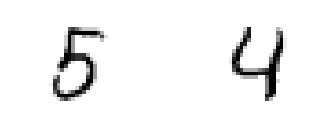

In [40]:
for i, image in enumerate([image1, image2]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow( (np.reshape(image, (28, 28)) * 255).astype(np.uint8), cmap=plt.cm.gray_r, interpolation='nearest')

Build scoring disctionary consisting of two digits and send it to deployed model to get predictions.

In [41]:
scoring_data = {'inputs': [image1, image2]}

In [42]:
predictions = client.deployments.score(scoring_url, scoring_data)
print("Scoring result: " + str(predictions))

Scoring result: {'classes': [5, 4]}


<a id="summary"></a>
## 6. Summary and next steps     

 You successfully completed this notebook! You learned how to use `watson-machine-learning-client` to train and score TensorFlow models. Check out our _[Online Documentation](https://console.ng.bluemix.net/docs/services/PredictiveModeling/index.html)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Lukasz Cmielowski**, PhD, is a Automation Architect and Data Scientist in IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

Copyright © 2017 IBM. This notebook and its source code are released under the terms of the MIT License.